In [5]:
#The objective of this project is to create a list of 10 movie recommendations based on a movie you previously enjoyed; Utilizing K-Nearest Neighbours Regression, we will find most similar movies
#Based on Genre, Director

#This dataset was procured from Kaggle by user Kashifsahil from URL:https://www.kaggle.com/datasets/kashifsahil/16000-movies-1910-2024-metacritic


In [37]:
pio.renderers.default = 'svg'

In [305]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'
import cufflinks as cf
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
import numpy as np
from scipy.stats import shapiro
import scipy.stats as stats

In [39]:
movie_data= pd.read_csv("16k_Movies.csv")

In [40]:
movie_data.head()

,Unnamed: 0,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Written by,Duration,Genres
0,0,Dekalog (1988),"Mar 22, 1996",This masterwork by Krzysztof Kieślowski is one...,7.4,118,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz",9 h 32 m,Drama
1,1,Three Colors: Red,"Nov 23, 1994",Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz, Ag...",1 h 39 m,"Drama,Mystery,Romance"
2,2,The Conformist,"Oct 22, 1970","Set in Rome in the 1930s, this re-release of B...",7.3,106,Bernardo Bertolucci,"Alberto Moravia, Bernardo Bertolucci",1 h 47 m,Drama
3,3,Tokyo Story,"Mar 13, 1972",Yasujiro Ozu’s Tokyo Story follows an aging co...,8.1,147,Yasujirô Ozu,"Kôgo Noda, Yasujirô Ozu",2 h 16 m,Drama
4,4,The Leopard (re-release),"Aug 13, 2004","Set in Sicily in 1860, Luchino Visconti's spec...",7.8,85,Luchino Visconti,"Giuseppe Tomasi di Lampedusa, Suso Cecchi D'Am...",3 h 7 m,"Drama,History"


In [41]:
list(movie_data)

['Unnamed: 0',
 'Title',
 'Release Date',
 'Description',
 'Rating',
 'No of Persons Voted',
 'Directed by',
 'Written by',
 'Duration',
 'Genres']

In [42]:
#First we will conduct Data Preprocessing by checking the shape of the data
movie_data.shape

(16290, 10)

In [43]:
#Before we make any modifications to the data we will need to check for empty cells, i.e. checking for NA values
null_count=movie_data.isnull().sum()
null_count
#there appear to be high null counts for Rating, No.people voted, Directed by, Written by, Duration and Genres.
#Since there are 16000 movies available, with the removal of null values, we can still construct a decent model, however this would affect the completeness of the dataset; 
#the "Written by" variable may be empty as it may not be based on a book, or it may have been written and directed by the same person; for example Quentin Tarantino.
#In this case it may be better off to omit the writer and focus solely on the director of the movie.
#movies showcasing an NA value for rating and no.of persons voted should be omitted to retain the completeness of the dataframe.

Unnamed: 0                0
Title                     0
Release Date              0
Description               0
Rating                 3444
No of Persons Voted    3461
Directed by               7
Written by              963
Duration                 13
Genres                    5
dtype: int64

In [44]:
movie_data.dtypes
#Upon inspection of the data, rating is float64 but should be numeric, Duration should be numeric perhaps it should be quantified in minutes rather than "h"m.
#Directors and Written by have may have more than 1 name; in this instance we should split for each distinct name which is seperated by a comma ","
#perhaps we can add an additional variable "rating volume" which would be the rating multiplied by the number of persons voted; since we are looking for acclaimed titles, a movie 1 or 2 people like may
#pale in comparison to one that has been watched many times.

Unnamed: 0               int64
Title                   object
Release Date            object
Description             object
Rating                 float64
No of Persons Voted     object
Directed by             object
Written by              object
Duration                object
Genres                  object
dtype: object

In [45]:
#firstly, we will change the datatype of the release date variable into datetime
movie_data.loc[:,'Release Date']=pd.to_datetime(movie_data['Release Date'], format="%b %d, %Y")
movie_data['Release Date']

0       1996-03-22
1       1994-11-23
2       1970-10-22
3       1972-03-13
4       2004-08-13
           ...    
16285   2001-04-27
16286   2010-12-10
16287   2000-10-01
16288   2003-06-20
16289   2003-01-17
Name: Release Date, Length: 16290, dtype: datetime64[ns]

In [46]:
movie_data_dropped= movie_data.dropna()
movie_data_dropped.shape
#Number of movies that are compelete with all columns is 12335, however a possible 963 of these movies may have been dropped due to "written by" variable which was previously mentioned to be omitted in
#preface of the director.

(12335, 10)

In [47]:
#the missing values may account for the Director being omitted rather than the writer and vice versa; as there are more NA values to the Writer than the Director, we will see if we can fill the 
#Missing directors with the writers in this case. Since Director column comes before Writer column, we will use bfill to fill the NA values in the Directors column.

movie_data['Directed by'].fillna(movie_data['Written by']).isnull().sum()
#as you can see we have managed to salvage 1 movie (from 7 to 6) by filling out NA Director values with possible Complete Writer values.

6

In [48]:
movie_data['Directed by']= movie_data['Directed by'].fillna(movie_data['Written by'])
movie_data_1= movie_data.drop(["Written by"], axis=1) #Now that the Directors are as complete as possible we will drop the Writers column
list(movie_data_1)



['Unnamed: 0',
 'Title',
 'Release Date',
 'Description',
 'Rating',
 'No of Persons Voted',
 'Directed by',
 'Duration',
 'Genres']

In [49]:
#given that Duration, Genres and Rating must be complete we will drop rows with NA values now.
movie_complete = movie_data_1.dropna()
movie_complete.shape
#by removing writers and filling missing directors, we managed so salvage 509 additional movies for the purposes of this project.

(12824, 9)

In [50]:
#Now we will confirm that the dataset is now free of na values
movie_complete.isnull().sum()

Unnamed: 0             0
Title                  0
Release Date           0
Description            0
Rating                 0
No of Persons Voted    0
Directed by            0
Duration               0
Genres                 0
dtype: int64

In [51]:
#Another column that can be removed is the "unnamed: 0" column which serves as an index; this column serves no purpose for EDA thus can be removed to improve simplicity of the data
movie_complete= movie_complete.drop(["Unnamed: 0"], axis=1)

In [52]:
movie_complete.dtypes

Title                          object
Release Date           datetime64[ns]
Description                    object
Rating                        float64
No of Persons Voted            object
Directed by                    object
Duration                       object
Genres                         object
dtype: object

In [53]:
#Preprocessing 1.2 
#The data types of each column is important where our goal is to not only explore the data and observe analysis; we want to create a machine learning model that can output recommendations based on
#Similar values; thusly all values should be changed to their correct corresponding data types.
#an object according to the Pandas repository means that it is made up of mixed data; 
#the Title and description makes sense to be an object type as it may contain strings and numerical values such as
#a sequel such as "Cars 2"

#Rating should be numerical to 1 decimal place, however since integers cannot have a decimal point value, it will remain as a float64 format.
#No. of persons voted should be numerical
#Directed by is a bit complicated where there may be more than 1 director on board for the movie; it may make sense to add an additional column for the "Number of directors" as well as a column 
#indicating for sub directors etc.
#Duration is considered an object because of its format e.g. 2h 15m, this will need to be turned to a numerical value and will make sense to change this entirely into minutes so that it becomes comparable
#Genres should be categorical, and much like the directors, some movies have more than 1 genre so it may have to be split among more columns. This may be simpler than directors.

In [54]:
#When dropping rows with dropna() functions, it does not remove the row indices, so it must be reset with "reset_index(drop=True, inplace=True)" function.
movie_complete.reset_index(drop=True, inplace=True)

In [55]:
#From inspection of the dataset, No of Persons Voted for values above 999 will place a comma "," for every thousand e.g. "1,000", to turn this into numerical value we will need to remove this comma with
#str.replace
movie_complete['No of Persons Voted']=movie_complete['No of Persons Voted'].str.replace(',','')
movie_complete['No of Persons Voted']=movie_complete['No of Persons Voted'].astype('int')

In [56]:
#Now we will work on duration
def convert_to_minutes(time_str):
    try:
        # Split the string into components, removing extra spaces
        parts = time_str.strip().split()
        
        # Ensure we have the correct format ('x h y m')
        if len(parts) == 4 and parts[1] == 'h' and parts[3] == 'm':
            hours = int(parts[0])  # Extract the hour part
            minutes = int(parts[2])  # Extract the minute part
            total_minutes = hours * 60 + minutes  # Convert to total minutes
            return total_minutes
        else:
            return None  # Return None if the format is incorrect
    except Exception as e:
        return None  # Handle any unexpected format issues
movie_complete['Duration'] = movie_complete['Duration'].apply(convert_to_minutes)

In [57]:
#From inspection of the data, the Duration column had some string values that were not conistent with the x h y m values, thus the else: function was added to return values inconistent with a null value.
movie_complete['Duration'].isnull().sum()

319

In [58]:
#Thus NA values will be dropped again and index will be reset.
movie_complete= movie_complete.dropna()
movie_complete.reset_index(drop=True, inplace=True)


In [59]:
movie_complete['Duration']=movie_complete['Duration'].astype('int')

In [60]:
movie_complete['Duration'].dtypes
#Duration was successfully changed to an integer

dtype('int32')

In [61]:
#In the case of Directors and Genre, we will have to conduct encoding to surmise a integer valuation; this will be done further down the analysis after the EDA is complete;
#However, we can learn from how many directors being present in a movie can affect ratings, thus we can construct an additional variable being "No of Directors"
movie_complete['Number of Directors'] = movie_complete['Directed by'].apply(lambda x: len(x.split(', ')))
#The x.split works by grouping elements that are seperated by the comma and space between each director. if we were not to add the comma, then the first and last name will be considered 2 unique directors.

In [62]:
movie_complete['Number of Directors'].max()
#From inspection the highest number of Directors for a single movie is 14, shocking!

14

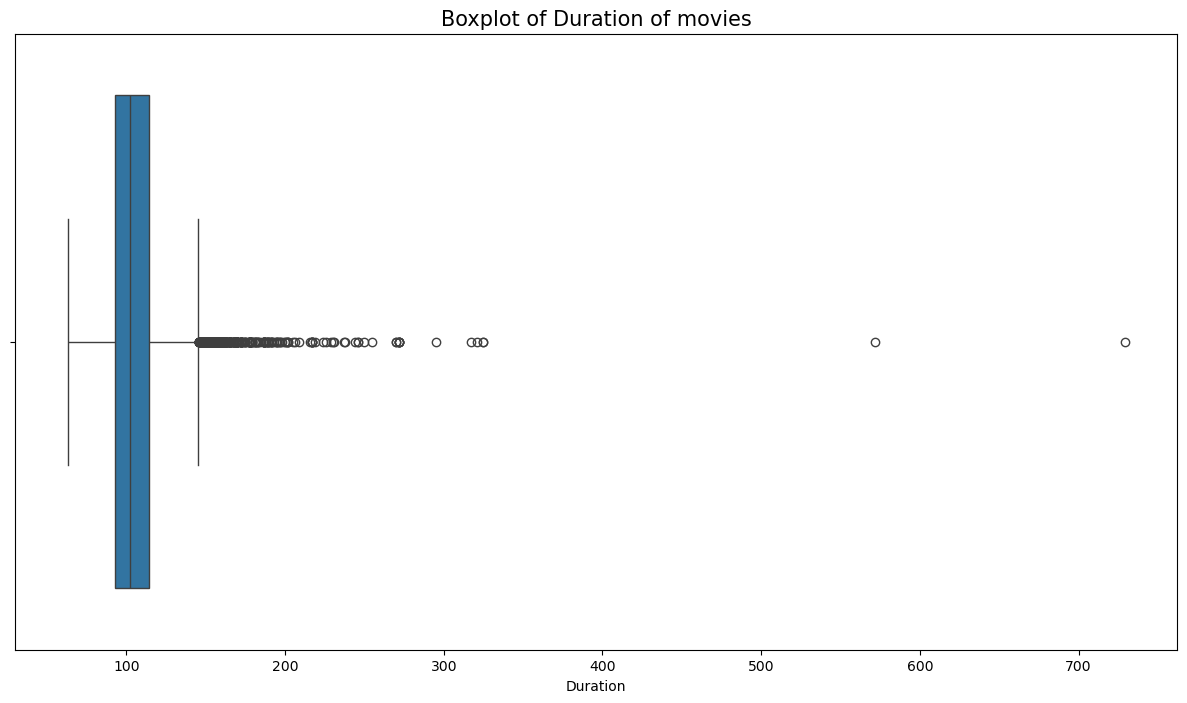

In [63]:
#Lets have a look at outliers
plt.figure(figsize = (15,8))
sns.boxplot(x=movie_complete['Duration']).set_title('Boxplot of Duration of movies', fontsize = 15)
plt.show();

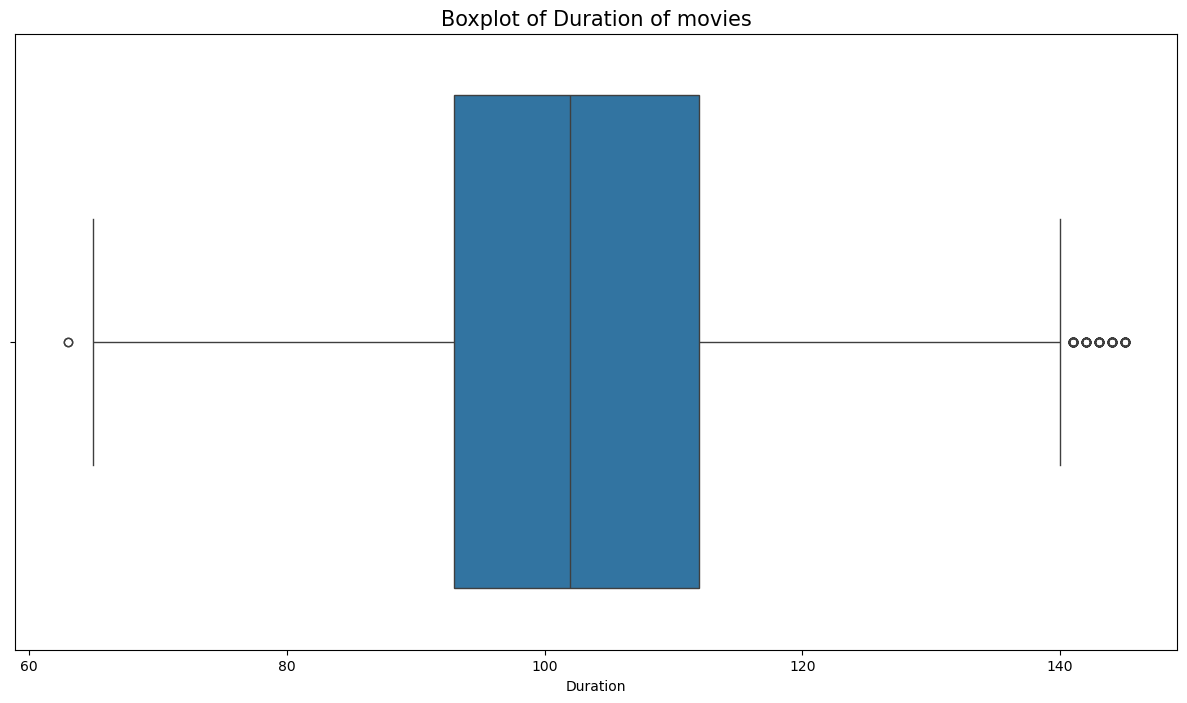

In [64]:
Q1 = movie_complete['Duration'].quantile(0.25)
Q3 = movie_complete['Duration'].quantile(0.75)
IQR = Q3 - Q1
movie_comp2 = movie_complete[(movie_complete['Duration'] >= (Q1 - 1.5 * IQR)) & (movie_complete['Duration'] <= (Q3 + 1.5 * IQR))]
plt.figure(figsize = (15,8))
sns.boxplot(x=movie_comp2['Duration']).set_title('Boxplot of Duration of movies', fontsize = 15)
plt.show();

In [65]:
movie_complete['Duration'].max()
#From inspection the longest movie goes for 729 minutes...
#This may cause issues in terms of outliers so we will apply a quick fix for both directors and duration to remove outliers out of the IQR.


729

In [66]:
#For purposes of EDA, since some movies contain multiple genres, we will assume that the first output genre is the primary genre and we will extract that as a seperate column
movie_complete['Genres'] = movie_complete['Genres'].str.replace(',', ', ', regex=False) #Some genres have a "," split rather than a ", " split so we will need to normalize these seperators to all have a ", "
movie_complete['Primary Genre'] = movie_complete['Genres'].apply(lambda x: x.split(', ')[0] if len(x.split(', ')) > 0 else None) #We are fetching the first element [0] with each element being seprated by ", "

In [67]:
#Since Genre is categorical, we should change the data type from object to category
movie_complete['Primary Genre']=movie_complete['Primary Genre'].astype('category')

In [68]:
#Lets output a list of the primary genres to make sure everything looks correct:
movie_complete['Primary Genre'].cat.categories

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War'],
      dtype='object')

In [69]:
movie_complete.dtypes
#The data types of each column is now ready for Exploratory Data Analysis.

Title                          object
Release Date           datetime64[ns]
Description                    object
Rating                        float64
No of Persons Voted             int32
Directed by                    object
Duration                        int32
Genres                         object
Number of Directors             int64
Primary Genre                category
dtype: object

In [70]:
movie_complete.head()

,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Duration,Genres,Number of Directors,Primary Genre
0,Dekalog (1988),1996-03-22,This masterwork by Krzysztof Kieślowski is one...,7.4,118,Krzysztof Kieslowski,572,Drama,1,Drama
1,Three Colors: Red,1994-11-23,Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,99,"Drama, Mystery, Romance",1,Drama
2,The Conformist,1970-10-22,"Set in Rome in the 1930s, this re-release of B...",7.3,106,Bernardo Bertolucci,107,Drama,1,Drama
3,Tokyo Story,1972-03-13,Yasujiro Ozu’s Tokyo Story follows an aging co...,8.1,147,Yasujirô Ozu,136,Drama,1,Drama
4,The Leopard (re-release),2004-08-13,"Set in Sicily in 1860, Luchino Visconti's spec...",7.8,85,Luchino Visconti,187,"Drama, History",1,Drama


In [71]:
#Lets have a look at the summary statistics for each of the numeric variables (Rating, No of persons voted, Duration, Number of Directors)
selected_columns= movie_complete[['Rating','No of Persons Voted','Duration','Number of Directors']]
summary_stats = pd.DataFrame({
    'Mean': selected_columns.mean(),
    'Median': selected_columns.median(),
    'Mode': selected_columns.mode().iloc[0],  # Use iloc[0] to get the first mode
    'Standard Deviation': selected_columns.std()
})
summary_stats

,Mean,Median,Mode,Standard Deviation
Rating,6.615730,6.8,7.0,1.412536
No of Persons Voted,134.807997,32.0,4.0,361.403013
Duration,105.640624,102.0,90.0,20.227440
Number of Directors,1.096921,1.0,1.0,0.375656


In [72]:
#The highest rated movie purely from rating is "A Hole in My Heart"
movie_complete.loc[movie_complete['Rating'].idxmax()]

Title                                                 A Hole in My Heart
Release Date                                         2005-04-08 00:00:00
Description            A brave, shocking cinematic experience intimat...
Rating                                                              10.0
No of Persons Voted                                                   14
Directed by                                              Lukas Moodysson
Duration                                                              98
Genres                                                             Drama
Number of Directors                                                    1
Primary Genre                                                      Drama
Name: 11605, dtype: object

In [73]:
#The lowest rated movie purely from rating is "Unpregnant"
movie_complete.loc[movie_complete['Rating'].idxmin()]

Title                                                         Unpregnant
Release Date                                         2020-09-10 00:00:00
Description            Seventeen-year-old Veronica (Haley Lu Richards...
Rating                                                               0.3
No of Persons Voted                                                  709
Directed by                                        Rachel Lee Goldenberg
Duration                                                             103
Genres                                                     Comedy, Drama
Number of Directors                                                    1
Primary Genre                                                     Comedy
Name: 6353, dtype: object

In [74]:
count_genres=movie_complete.groupby(['Primary Genre']).size()
df_count_genres = count_genres.reset_index(name='Count')
df_count_genres= df_count_genres.sort_values(by='Count',ascending=False)
df_count_genres

,Primary Genre,Count
4,Comedy,3035
7,Drama,2877
0,Action,2156
6,Documentary,1120
5,Crime,900
3,Biography,690
11,Horror,567
1,Adventure,521
2,Animation,473
9,Fantasy,65


In [75]:
df = df_count_genres.sort_values(by='Count', ascending=False).reset_index(drop=True)
df['Primary Genre']=pd.Categorical(df['Primary Genre'], categories=df['Primary Genre'], ordered=True)
order = df['Primary Genre']

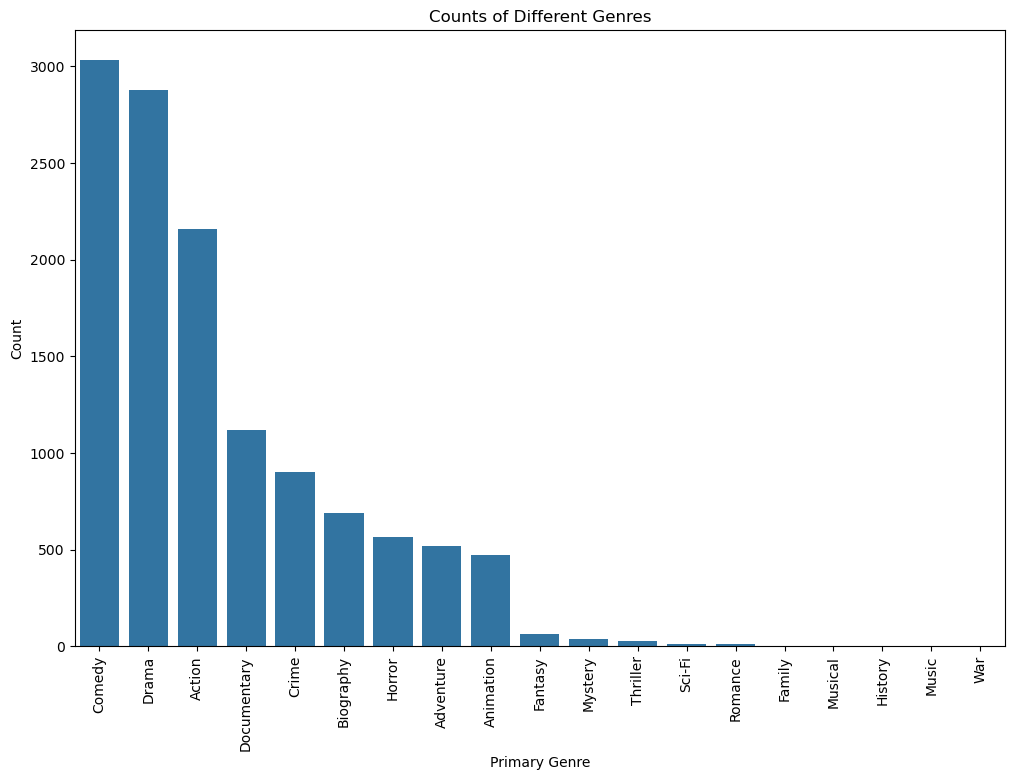

In [76]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Primary Genre', y='Count', data=df, order= order)

# Rotate x labels for better readability
plt.xticks(rotation=90)

plt.title('Counts of Different Genres')
plt.xlabel('Primary Genre')
plt.ylabel('Count')

plt.show()

In [77]:
#EDA to analyse: what constitutes a good movie? 

In [78]:
#Genre trends for movies each year, what are the top 3 primary genre movies for each year?
movie_complete['Year'] = movie_complete['Release Date'].dt.year
movie_filter= movie_complete[(movie_complete['Year'] >= 2018) & (movie_complete['Year'] <= 2023)]
genre_counts = movie_filter.groupby(['Year', 'Primary Genre']).size().reset_index(name='Count')
top_3_genres_per_year = genre_counts.groupby('Year').apply(lambda x: x.nlargest(3, 'Count')).reset_index(drop=True)

genres_to_keep = ['Drama', 'Comedy', 'Action', 'Documentary']
genres_to_keep
top_3_genres_per_year = top_3_genres_per_year[top_3_genres_per_year['Primary Genre'].isin(genres_to_keep)]
top_3_genres_per_year['Primary Genre'] = pd.Categorical(top_3_genres_per_year['Primary Genre'], categories=genres_to_keep)
top_3_genres_per_year['Primary Genre']
#We also want to have a look at the proportional differences:
total_counts = top_3_genres_per_year.groupby('Year')['Count'].sum().reset_index(name='TotalCount')
top_3_genres_per_year = top_3_genres_per_year.sort_values(['Year', 'Count'], ascending=[True, False]).groupby('Year').head(3)
top_3_genres_per_year = top_3_genres_per_year.merge(total_counts, on='Year')
top_3_genres_per_year['Proportion'] = top_3_genres_per_year['Count'] / top_3_genres_per_year['TotalCount']
top_3_genres_per_year

,Year,Primary Genre,Count,TotalCount,Proportion
0,2018,Drama,126,294,0.428571
1,2018,Comedy,88,294,0.299320
2,2018,Action,80,294,0.272109
3,2019,Drama,120,279,0.430108
4,2019,Action,80,279,0.286738
5,2019,Comedy,79,279,0.283154
6,2020,Drama,142,295,0.481356
7,2020,Comedy,95,295,0.322034
8,2020,Documentary,58,295,0.196610
9,2021,Drama,116,248,0.467742


In [79]:
#Going purely by the primary genre, it is clear to see what genres are the most popular for each year; on observation for every year for the preceding 5 years, Drama and Comedy
#Movies appear to be the most popular.

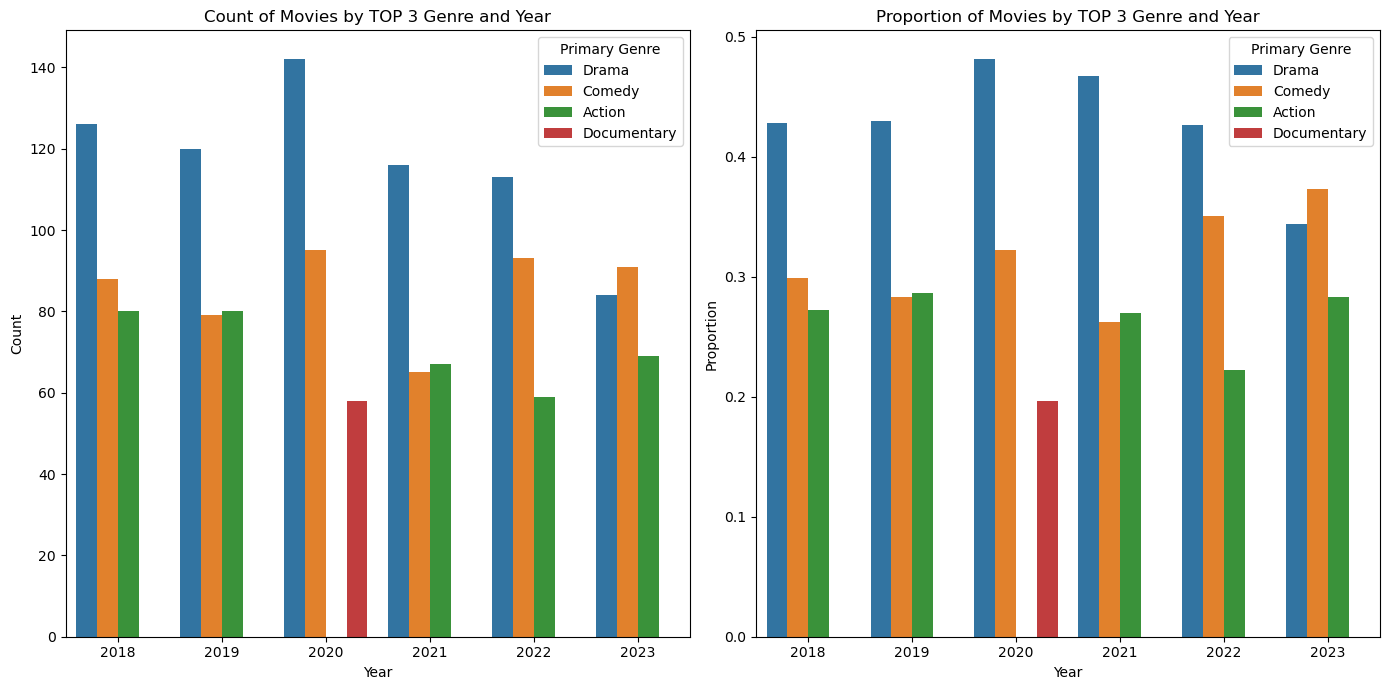

In [80]:
plt.figure(figsize=(14, 7))

# Bar plot for counts
plt.subplot(1, 2, 1)
sns.barplot(x='Year', y='Count', hue='Primary Genre', data=top_3_genres_per_year)
plt.title('Count of Movies by TOP 3 Genre and Year')
plt.xlabel('Year')
plt.ylabel('Count')

# Bar plot for proportions
plt.subplot(1, 2, 2)
sns.barplot(x='Year', y='Proportion', hue='Primary Genre', data=top_3_genres_per_year)
plt.title('Proportion of Movies by TOP 3 Genre and Year')
plt.xlabel('Year')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

In [164]:
#From observation, it is clear that for each of the years a high proportion of movies (over half!) are made up  solely out of drama and comedy movies. for the year 2020, 
#Action movies were less favoured compared to documentary style movies.

In [115]:
#Average rating per genre?
movie_genres_mean=movie_complete.groupby(['Primary Genre']).mean().sort_values(by='Rating', ascending= False).reset_index()
genre_order=movie_genres_mean['Primary Genre']
movie_genres_mean


,Primary Genre,Rating,No of Persons Voted,Duration,Number of Directors,Year
0,Music,8.100000,101.000000,93.000000,1.000000,2013.000000
1,Animation,6.890486,243.232558,93.475687,1.619450,2010.276956
2,Sci-Fi,6.850000,135.500000,100.785714,1.000000,1999.785714
3,Biography,6.849565,103.300000,117.524638,1.033333,2009.998551
4,History,6.800000,16.000000,118.000000,1.000000,2021.000000
5,Crime,6.799111,119.911111,110.273333,1.034444,2006.933333
6,Drama,6.690198,86.295447,108.896072,1.041710,2009.644074
7,Adventure,6.667370,179.735125,109.094050,1.046065,2005.727447
8,Family,6.666667,111.333333,108.333333,1.000000,2007.666667
9,Documentary,6.614643,24.740179,97.988393,1.301786,2012.650000


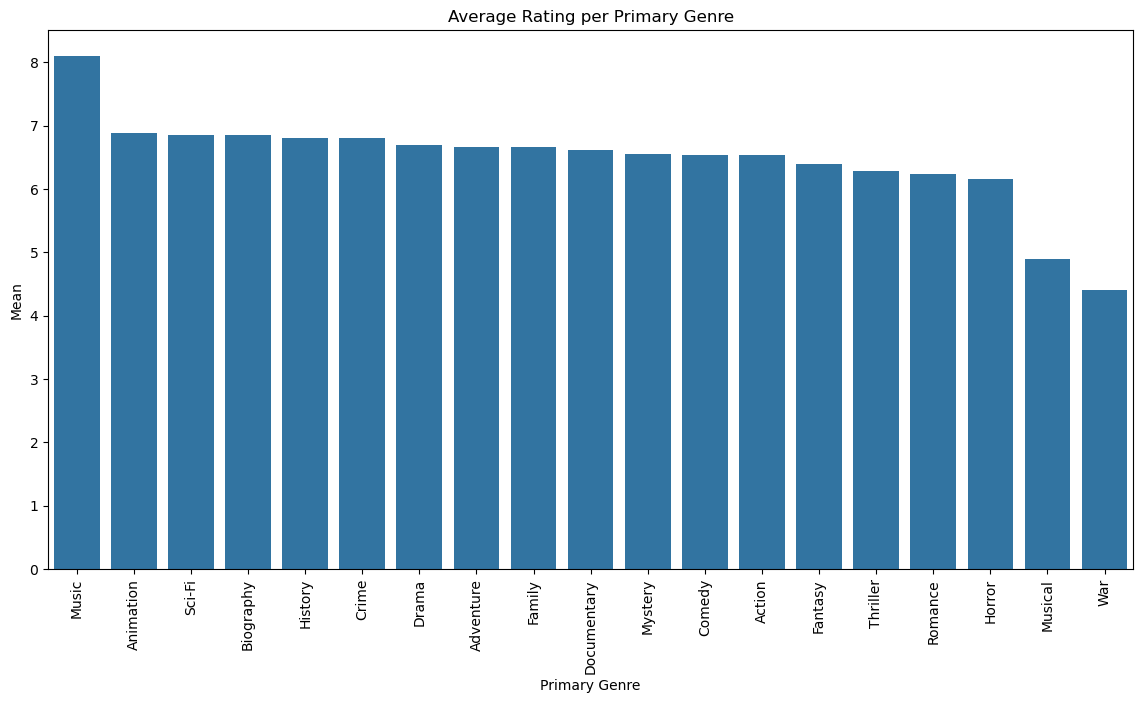

In [117]:
plt.figure(figsize=(14, 7))
sns.barplot(x='Primary Genre', y='Rating', data=movie_genres_mean, order=genre_order)
plt.xticks(rotation=90)

plt.title('Average Rating per Primary Genre')
plt.xlabel('Primary Genre')
plt.ylabel('Mean')

plt.show()

In [128]:
#Strangely, it seems that movies with a Music based primary genre has the highest average rating while Musical primary genres score far less at 4.9 on average? This seems
#to occur as musicals are usually not the primary genre of a movie but rather one of the subgenres, we may have to explore the correlation between genres; to see
#Which genres usually match best with another.
movie_complete.head()

,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Duration,Genres,Number of Directors,Primary Genre,Year
0,Dekalog (1988),1996-03-22,This masterwork by Krzysztof Kieślowski is one...,7.4,118,Krzysztof Kieslowski,572,Drama,1,Drama,1996
1,Three Colors: Red,1994-11-23,Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,99,"Drama, Mystery, Romance",1,Drama,1994
2,The Conformist,1970-10-22,"Set in Rome in the 1930s, this re-release of B...",7.3,106,Bernardo Bertolucci,107,Drama,1,Drama,1970
3,Tokyo Story,1972-03-13,Yasujiro Ozu’s Tokyo Story follows an aging co...,8.1,147,Yasujirô Ozu,136,Drama,1,Drama,1972
4,The Leopard (re-release),2004-08-13,"Set in Sicily in 1860, Luchino Visconti's spec...",7.8,85,Luchino Visconti,187,"Drama, History",1,Drama,2004


In [210]:
#Lets filter out movies with a single genre and focus on movies with 2 or more genres and have a look at the first 2 listed genres for each movie and 
#conduct correlation analysis to see which genre types work best together.
 movie_complete['genre_count'] = movie_complete['Genres'].apply(lambda x: len([genre.strip() for genre in x.split(',')]))

IndentationError: unexpected indent (2446234872.py, line 3)

In [211]:
genre_count_movie= movie_complete[movie_complete['genre_count'] > 1].reset_index(drop=True)
genre_count_movie.head(n=10)

,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Duration,Genres,Number of Directors,Primary Genre,Year,genre_count,Subgenre
0,Three Colors: Red,1994-11-23,Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,99,"Drama, Mystery, Romance",1,Drama,1994,3,Mystery
1,The Leopard (re-release),2004-08-13,"Set in Sicily in 1860, Luchino Visconti's spec...",7.8,85,Luchino Visconti,187,"Drama, History",1,Drama,2004,2,History
2,The Godfather,1972-03-24,Francis Ford Coppola's epic features Marlon Br...,9.3,4102,Francis Ford Coppola,175,"Crime, Drama",1,Crime,1972,2,Drama
3,Lawrence of Arabia (re-release),2002-09-20,The 40th anniversary re-release of David Lean'...,8.6,446,David Lean,216,"Adventure, Biography, Drama, War",1,Adventure,2002,4,Biography
4,Army of Shadows,2006-04-28,"Making its U.S. debut, Jean-Pierre Melville's ...",7.7,67,Jean-Pierre Melville,145,"Drama, War",1,Drama,2006,2,War
5,Pépé le Moko (re-release),2002-03-01,A re-release of Julien Divivier's 1937 romanti...,6.3,23,Julien Duvivier,94,"Crime, Drama, Romance",1,Crime,2002,3,Drama
6,Pan's Labyrinth,2006-12-29,"Following a bloody civil war, young Ofelia ent...",8.8,1872,Guillermo del Toro,118,"Drama, Fantasy, War",1,Drama,2006,3,Fantasy
7,Hoop Dreams,1994-10-14,Two inner-city Chicago boys with hopes of beco...,8.2,120,Steve James,170,"Documentary, Drama, Sport",1,Documentary,1994,3,Drama
8,Metropolis (re-release),2002-07-12,Possibly the crowning achievement of silent ci...,8.6,233,Fritz Lang,153,"Drama, Sci-Fi",1,Drama,2002,2,Sci-Fi
9,My Left Foot,1989-11-10,"True story of cerebral palsied Christy Brown, ...",8.3,111,Jim Sheridan,103,"Biography, Drama",1,Biography,1989,2,Drama


In [212]:
#We have returned all movies with more than 1 genre, we want to return the second element as the "Subgenre", since we already have the first element (Primary genre)
genre_count_movie['Subgenre'] = genre_count_movie['Genres'].apply(lambda x: x.split(', ')[1] if len(x.split(',')) > 1 else None) #We are fetching the first element [0] with each element being seprated by ", "

In [260]:
rating_genres=genre_count_movie[['Rating','Primary Genre','Subgenre']]
rating_genres['Subgenre']=rating_genres['Subgenre'].astype('category')

In [219]:
contingency_table = pd.crosstab(rating_genres['Primary Genre'], rating_genres['Subgenre'])
avg_rating = rating_genres.pivot_table(index='Primary Genre', columns='Subgenre', values='Rating', aggfunc='mean')
avg_rating = avg_rating.fillna(0)

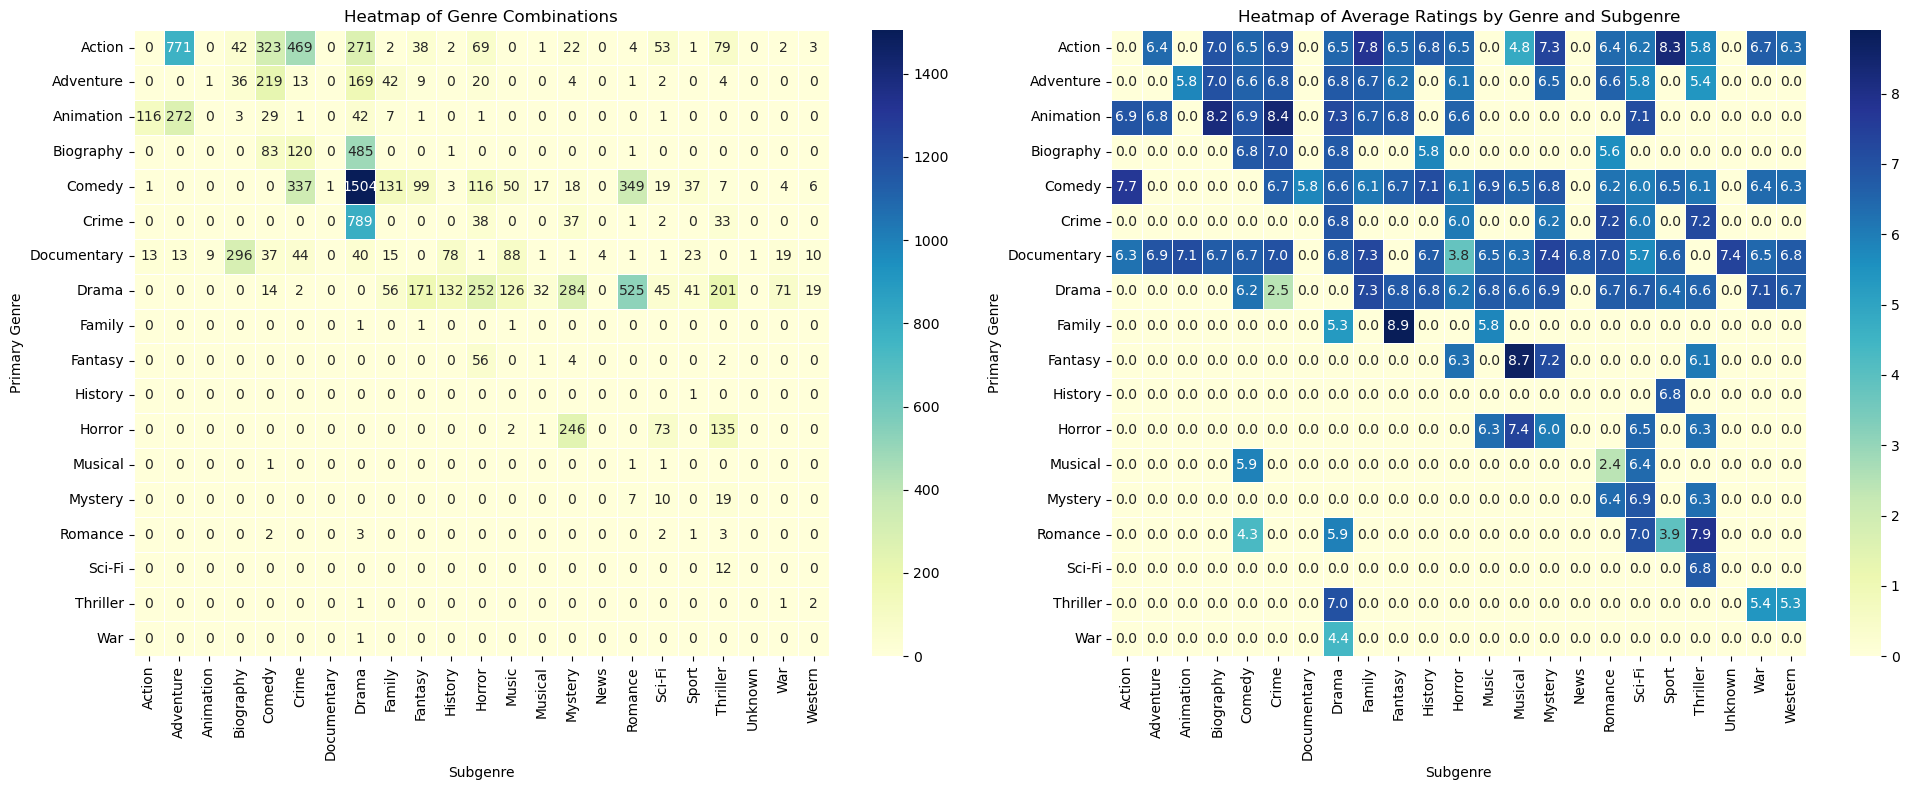

In [273]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d', linewidths=.5)
plt.title('Heatmap of Genre Combinations')

plt.subplot(1, 2, 2)
sns.heatmap(avg_rating, annot=True, cmap='YlGnBu', fmt='.1f', linewidths=.5)
plt.title('Heatmap of Average Ratings by Genre and Subgenre')
plt.xlabel('Subgenre')
plt.ylabel('Primary Genre')
plt.tight_layout()
plt.show()

In [249]:
#Is there "Hype" associated with movies with high ratings? i.e. is there a relationship between high numbers of persons rated vs. movie ratings?
#Firstly lets have a look at the distribution of no.of persons voted.


In [283]:
logratings= np.log1p(movie_complete['No of Persons Voted'])
log_ratings = np.array(logratings)
mean_log_ratings = log_ratings.mean()
std_dev_log_ratings = log_ratings.std()
log_ratings_boxcox, lambda_opt = stats.boxcox(log_ratings - log_ratings.min() + 1)
ratings_boxcox, lambda_opt = stats.boxcox(movie_complete['No of Persons Voted'] - movie_complete['No of Persons Voted'].min() + 1)


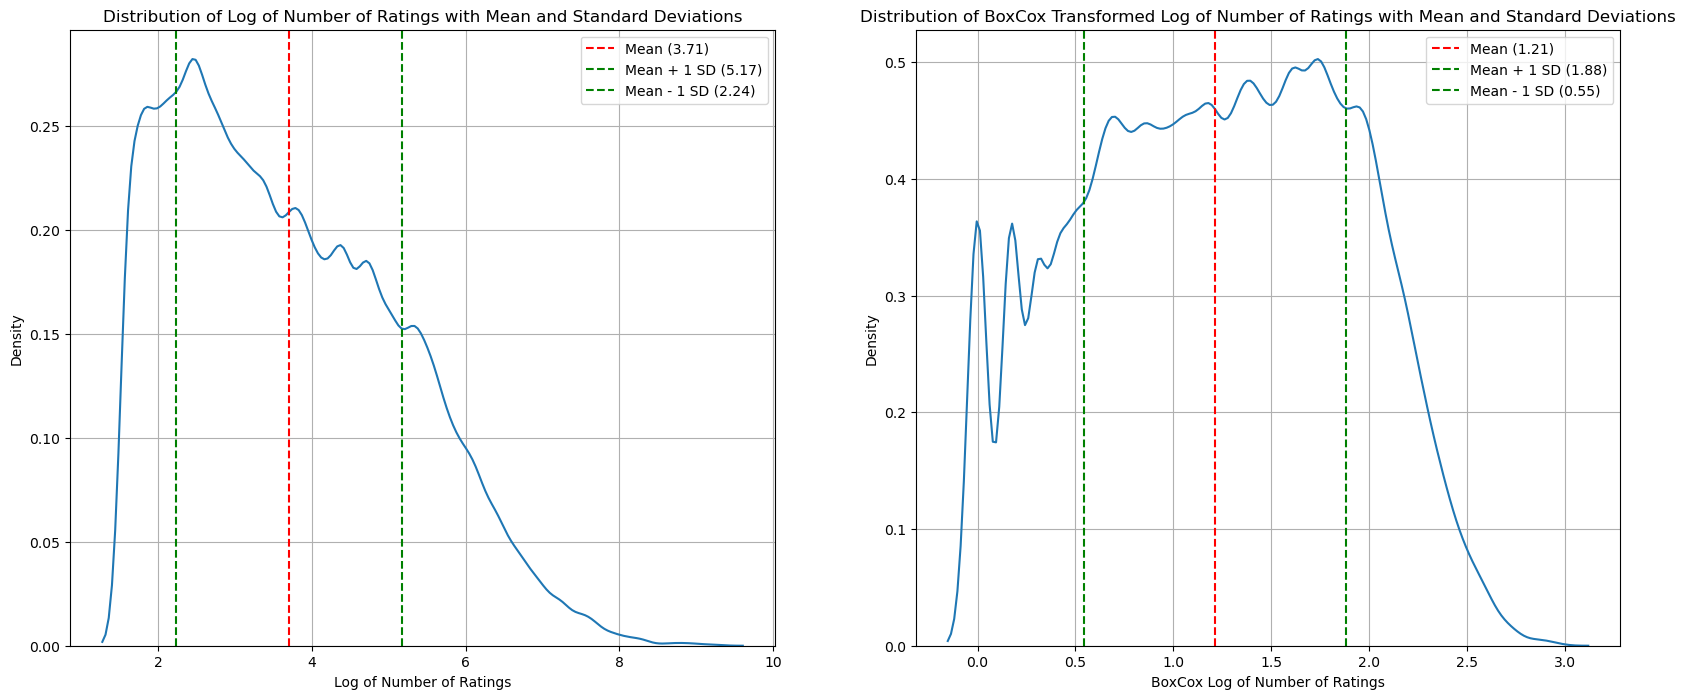

In [300]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
x = np.linspace(log_ratings.min(), log_ratings.max(), 100)

# Calculate the density using Kernel Density Estimate (KDE)
sns.kdeplot(log_ratings, bw_adjust=0.5)
plt.xlabel('Log of Number of Ratings')
plt.ylabel('Density')

# Add vertical lines for mean and standard deviations
plt.axvline(mean_log_ratings, color='red', linestyle='--', label=f'Mean ({mean_log_ratings:.2f})')
plt.axvline(mean_log_ratings + std_dev_log_ratings, color='green', linestyle='--', label=f'Mean + 1 SD ({mean_log_ratings + std_dev_log_ratings:.2f})')
plt.axvline(mean_log_ratings - std_dev_log_ratings, color='green', linestyle='--', label=f'Mean - 1 SD ({mean_log_ratings - std_dev_log_ratings:.2f})')

plt.title('Distribution of Log of Number of Ratings with Mean and Standard Deviations')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
x = np.linspace(log_ratings.min(), log_ratings.max(), 100)
mean_boxcox_ratings = log_ratings_boxcox.mean()
std_dev_boxcox_ratings = log_ratings_boxcox.std()

# Calculate the density using Kernel Density Estimate (KDE)
sns.kdeplot(log_ratings_boxcox, bw_adjust=0.5)
plt.xlabel('BoxCox Log of Number of Ratings')
plt.ylabel('Density')

# Add vertical lines for mean and standard deviations
plt.axvline(mean_boxcox_ratings, color='red', linestyle='--', label=f'Mean ({mean_boxcox_ratings:.2f})')
plt.axvline(mean_boxcox_ratings + std_dev_boxcox_ratings, color='green', linestyle='--', label=f'Mean + 1 SD ({mean_boxcox_ratings + std_dev_boxcox_ratings:.2f})')
plt.axvline(mean_boxcox_ratings - std_dev_boxcox_ratings, color='green', linestyle='--', label=f'Mean - 1 SD ({mean_boxcox_ratings - std_dev_boxcox_ratings:.2f})')

plt.title('Distribution of BoxCox Transformed Log of Number of Ratings with Mean and Standard Deviations')
plt.legend()
plt.grid(True)
plt.show()

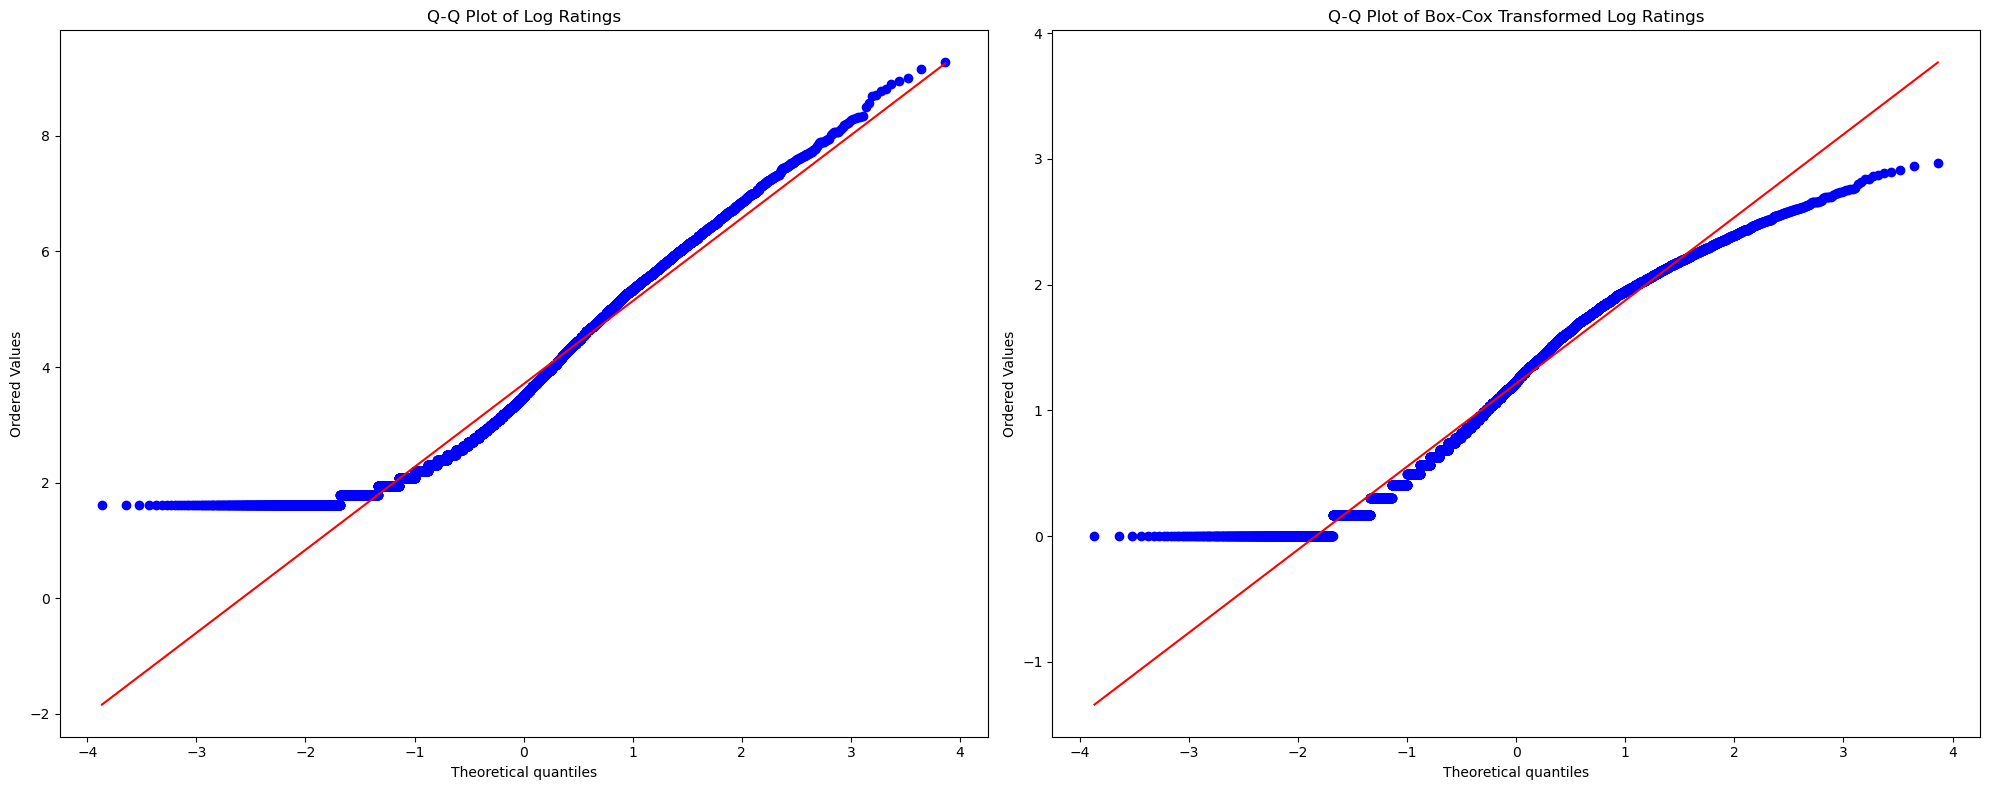

In [289]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
stats.probplot(log_ratings, dist="norm", plot=plt)
plt.title('Q-Q Plot of Log Ratings')

plt.subplot(1, 2, 2)

stats.probplot(log_ratings_boxcox, dist="norm", plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Log Ratings')

plt.tight_layout()
plt.show()

In [290]:
stat, p_value = shapiro(log_ratings)
print(f"Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}")

if p_value > 0.05:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")

Shapiro-Wilk Test: Statistic=0.9564703702926636, p-value=0.0
The data does not follow a normal distribution (reject H0).


In [291]:
stat, p_value = shapiro(log_ratings_boxcox)
print(f"Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}")

if p_value > 0.05:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")

Shapiro-Wilk Test: Statistic=0.9754432439804077, p-value=1.3739731442704831e-41
The data does not follow a normal distribution (reject H0).


In [ ]:
#It appears that for both transformed arrays, the Shapiro-Wilk Test advises that the data does not follow a normal distribution, however the sample size is extremely large
#being greater than 10,000, wherein the Central Limit Theorem states that for large sample sizes generally >30, the distribution of the mean wil be approximately normal. 
#Also, the qq plot shows that there are deviations mostly on the extremes of the tails (where it drags off the regression line), suggesting
#non normality is primarily on the extremes; this may allow us for parametric testing.

In [302]:
mean_score = movie_complete['Rating'].mean()
std_dev_score = movie_complete['Rating'].std()
score_boxcox, lambda_opt = stats.boxcox(movie_complete['Rating'] - movie_complete['Rating'].min()+1)
mean_boxcox_score= score_boxcox.mean()
std_dev_boxcox_score= score_boxcox.std()

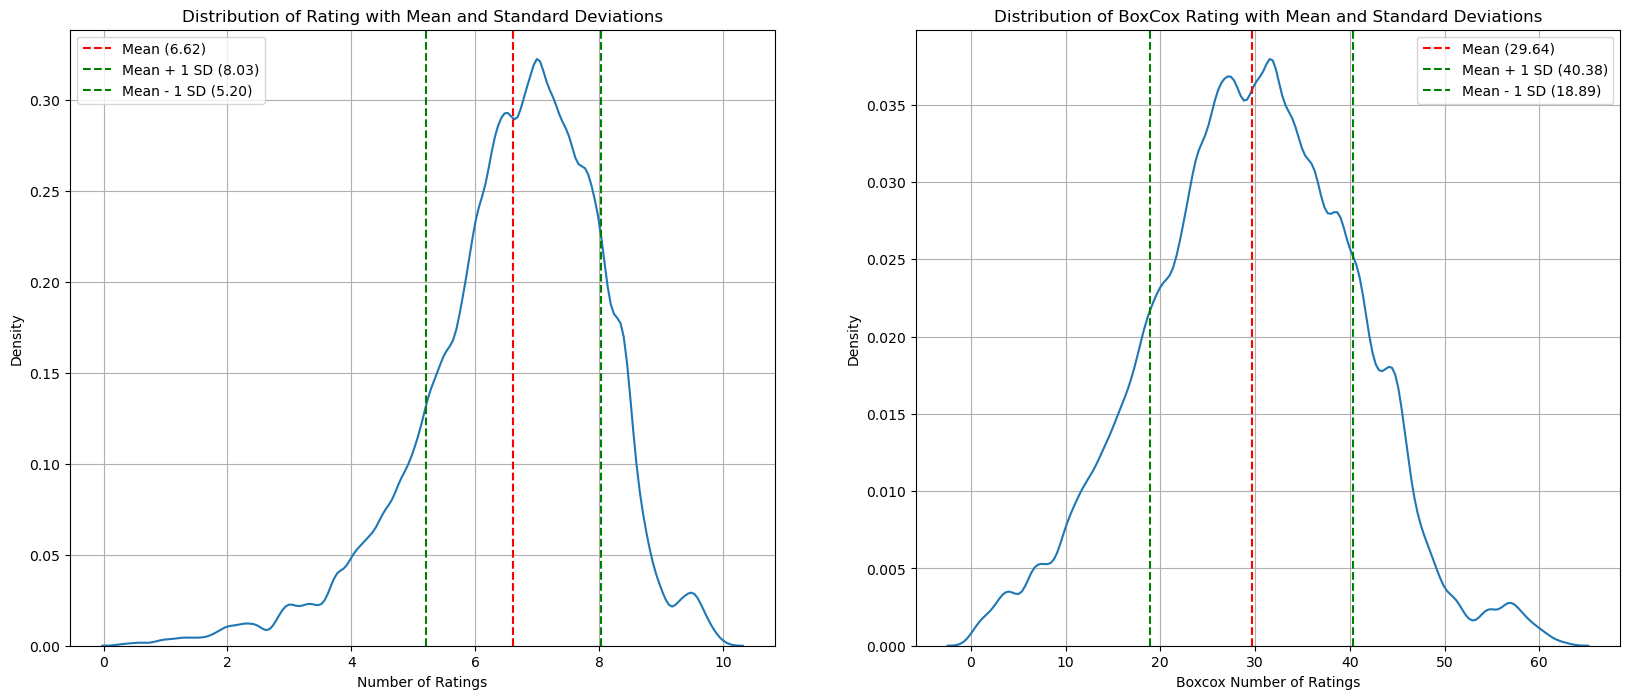

In [301]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
x = np.linspace(movie_complete['Rating'].min(), movie_complete['Rating'].max(), 100)

# Calculate the density using Kernel Density Estimate (KDE)
sns.kdeplot(movie_complete['Rating'], bw_adjust=0.5)
plt.xlabel('Number of Ratings')
plt.ylabel('Density')

# Add vertical lines for mean and standard deviations
plt.axvline(mean_score, color='red', linestyle='--', label=f'Mean ({mean_score:.2f})')
plt.axvline(mean_score + std_dev_score, color='green', linestyle='--', label=f'Mean + 1 SD ({mean_score + std_dev_score:.2f})')
plt.axvline(mean_score - std_dev_score, color='green', linestyle='--', label=f'Mean - 1 SD ({mean_score - std_dev_score:.2f})')

plt.title('Distribution of Rating with Mean and Standard Deviations')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# Calculate the density using Kernel Density Estimate (KDE)
sns.kdeplot(score_boxcox, bw_adjust=0.5)
plt.xlabel('Boxcox Number of Ratings')
plt.ylabel('Density')

# Add vertical lines for mean and standard deviations
plt.axvline(mean_boxcox_score, color='red', linestyle='--', label=f'Mean ({mean_boxcox_score:.2f})')
plt.axvline(mean_boxcox_score + std_dev_boxcox_score, color='green', linestyle='--', label=f'Mean + 1 SD ({mean_boxcox_score + std_dev_boxcox_score:.2f})')
plt.axvline(mean_boxcox_score - std_dev_boxcox_score, color='green', linestyle='--', label=f'Mean - 1 SD ({mean_boxcox_score - std_dev_boxcox_score:.2f})')
plt.legend()
plt.grid(True)
plt.title('Distribution of BoxCox Rating with Mean and Standard Deviations')
plt.show()

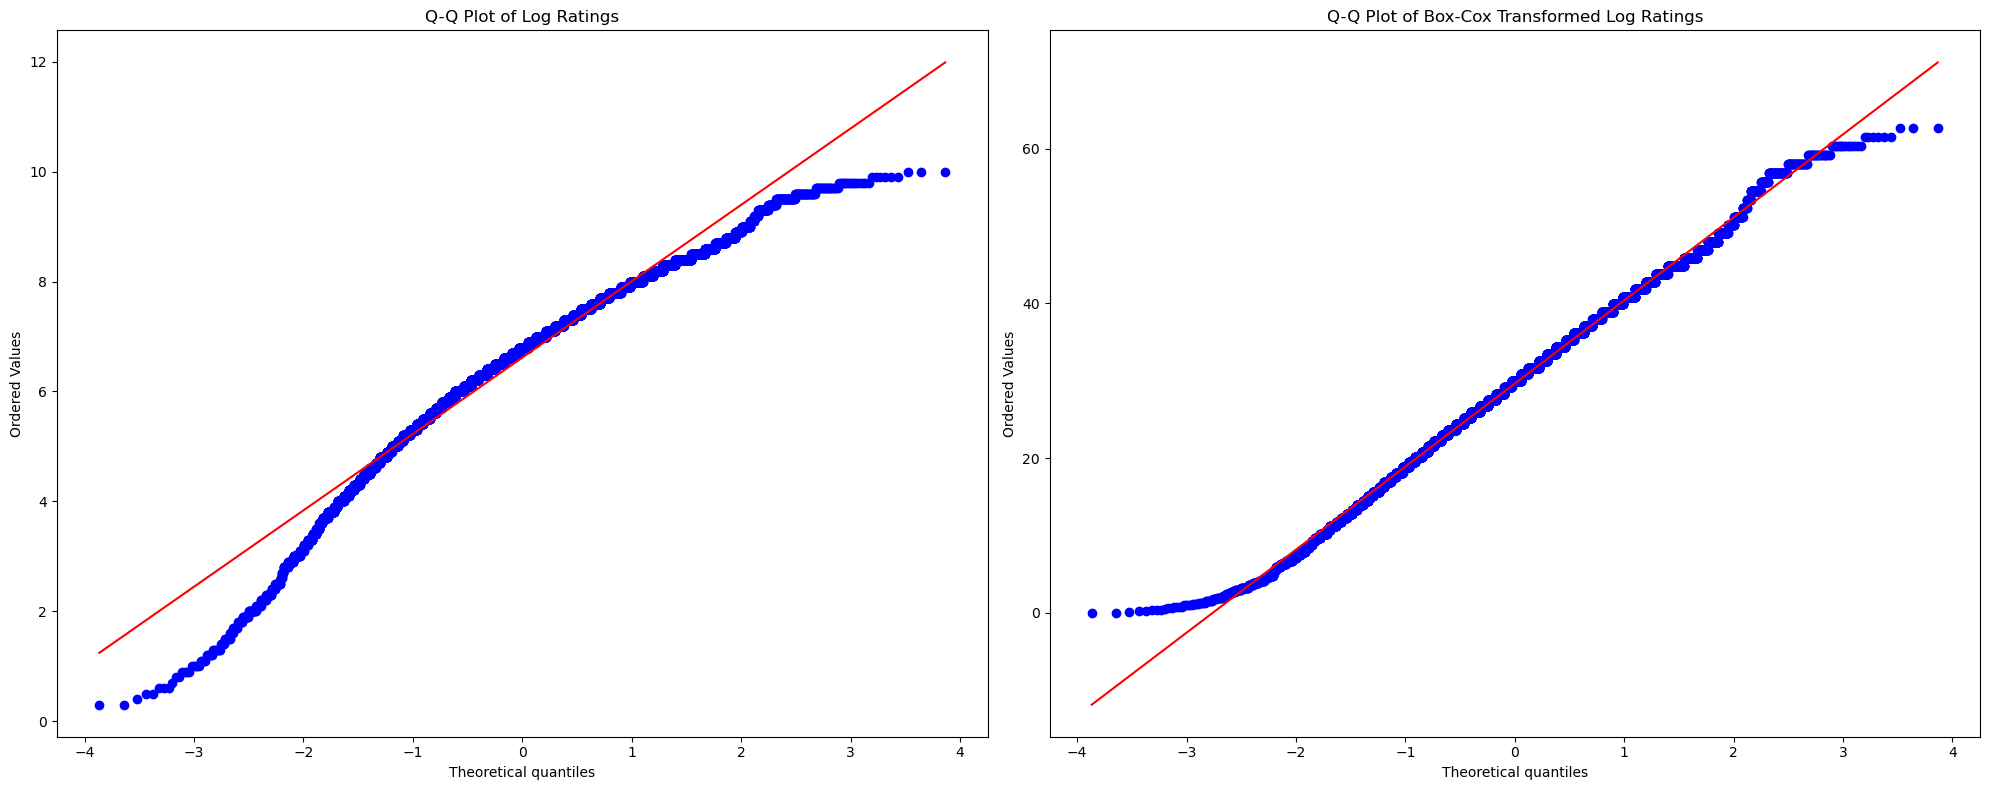

In [304]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
stats.probplot(movie_complete['Rating'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log Ratings')

plt.subplot(1, 2, 2)

stats.probplot(score_boxcox, dist="norm", plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Log Ratings')

plt.tight_layout()
plt.show()

In [296]:
stat, p_value = shapiro(score_boxcox)
print(f"Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}")

if p_value > 0.05:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")

Shapiro-Wilk Test: Statistic=0.9974043369293213, p-value=6.444509232901921e-14
The data does not follow a normal distribution (reject H0).


C:\Users\lkyou\anaconda3\envs\myenv\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning:

p-value may not be accurate for N > 5000.



In [310]:
#Correlation analysis provides insights on a positive or negative relationship ranging from -1 to 1, where in this case a value closer to -1 would exhibit a 1:1 
#inverse relationship with the number of voters vs the actual rating, while a value closer to 1 would exhibit a relationship where there is a positive 1:1 correlation
#in the number of voters vs the actual rating.
#In this case, we will be using Pearson Correlation due to the variables both being continuous; where we are observing to see if there is a linear relationship between the two.
#i.e. we were exploring if a higher number of voters = a higher score and vice versa.

In [308]:
correlation, p_value = stats.pearsonr(log_ratings, score_boxcox)
print(f"Pearson correlation: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation: 0.2944572153793603
P-value: 1.3933177140247722e-248


In [311]:
from scipy.stats import spearmanr
correlation, p_value = stats.spearmanr(log_ratings, score_boxcox)
print(f"Pearson correlation: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation: 0.29271425864494865
P-value: 1.5391094382124679e-245


In [330]:
#For both Pearsons and Spearman correlations, the amount of positive correlation is almost identical, where the p-value for both is so close to zero that it is 
#that the relationship between number of votes and the rating is indeed statistically significant however being quite weak. 
#This confirms that there definitely is a factor in which "hype" for a movie does statisically increase the rating of a movie.

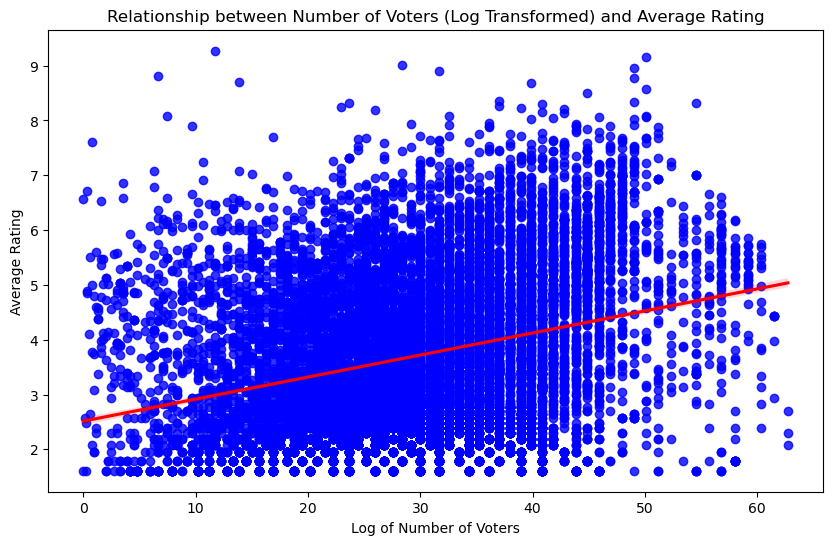

In [328]:
correlation_movies=pd.DataFrame({'boxcox_numbers':score_boxcox, 'log_ratings':log_ratings})
plt.figure(figsize=(10,6))
sns.regplot(x='boxcox_numbers', y='log_ratings', data=correlation_movies, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Relationship between Number of Voters (Log Transformed) and Average Rating')
plt.xlabel('Log of Number of Voters')
plt.ylabel('Average Rating')
plt.show()